# Tasks
### Explore and Pre-Process Data
The data is stored in nine Excel tables. I grouped them by denoting with letters and numbers for convenience.
- Load the data sets one by one and look at them.


- The tables don't have a DataFrame structure as they are stored in a way more convenient for Excel.<br>
Note: For all DataFrames population is given in thousands.
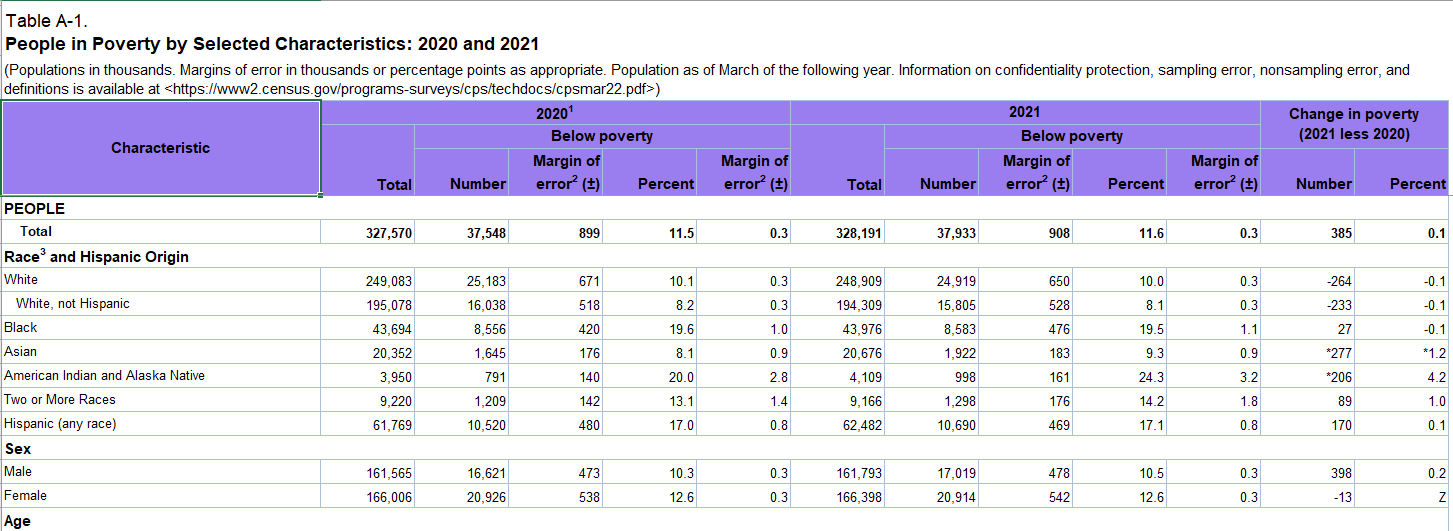



- So, each table read from Excel will be split into several subsets, based on the values in column A.


- All the tables don't look very messy despite not being made for the Python format. <br>
So, wrangling and tidying could be made underway on the loading stage. Data types could be changed right after a DataFrame is loaded.

### Analyze
1. How did the poverty situation change for three age groups (children, adults, seniors) across five races (white, Black, Hispanic, Asian, and Native) since the data started being collected (from 1959)? 


2. Explore the historical poverty based on five different measures (including or excluding benefit programs from the calculation).


3. Explore poverty in 2021 in the US by nine groups (age, sex, race, etc.).

<i>The data will be loaded gradually as the analysis proceeds.

### First, define the custom cleaning functions
Before loading and analyzing data, we need to create custom functions for further use. <br>
Plotting functions are defined later, each in a section if is needed

In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import squarify
import scipy.stats as stats

#### Cleaning functions

Extract specified rows from the dataset. It will be used to create a number of smaller DataFrames withdrawn from the original set.

In [2]:
def extract_rows(df, row_start, row_end, index_to_drop=None):
    new_df = df.iloc[row_start:row_end]
    if index_to_drop != None:
        new_df = new_df.drop(index_to_drop)
    return new_df.reset_index(drop=True)

Turn string values to NaNs and change all data types to float. As soon as all data in three of five original tables are numeric, but the values are read as objects for some reason, this function turns every numeric to float and strings to NaN.

In [3]:
def change_dtypes(df):
    for col in df.columns:
        if col == 'year':
            df[col] = df[col].apply(lambda x: str(x)[0:4])
        df[col] = pd.to_numeric(df[col], errors='coerce')

Print the name of the current DataFrame to the title. It would help us to print out some parts of the DataFrame name to the plot title.

In [4]:
def get_df_name(df):
    return [x for x in globals() if globals()[x] is df][0]

# Changes in Poverty over Time by Race
#### Question
Here we'll try to answer the question `How did the situation change for different races since the data started being collected?`<br>


#### Data
The first table contains information on poverty for five races + all the races since 1959. To extract a DataFrame from the table in which we could perform analysis, we'll split it into several frames for each group.<br> 
<i>Consideration: I don't include combinations of two or more races, so the analysis could be focused on the differences between  races.</i>

#### Methods
First, with the line chart we explore the change in the percentage of people in poverty in each group (3 age groups x 5 races). <br>
Second, we look at the change over time for these groups, choose the ones with an increase or decrease trend and run the Mann-Kendall test and find the Pearson correlation coefficient to check if it had been so.

#### Load and Clean Data

In [5]:
cols_1 = ['year', 'total_under_18', 'below_pov_under_18', 'pct_under_18', 'total_18_to_64', 'below_pov_18_to_64', 'pct_18_to_64', 'total_over_64', 'below_pov_over_64', 'pct_over_64']
df1 = pd.read_excel('b1_hist_pov_by_group_age.xlsx', skiprows=6, usecols="A:D, H:M", names=cols_1).iloc[0:464]
# Change numeric values to float and strings to NaN_
change_dtypes(df1)

In [6]:
hist_pov_all = extract_rows(df1, 1, 66)
hist_pov_white = extract_rows(df1, 67, 129, 89)
hist_pov_black = extract_rows(df1, 205, 265, 227)
hist_pov_asian = extract_rows(df1, 289, 327, 311)
hist_pov_native = extract_rows(df1, 351, 389, 373)
hist_pov_hispanic = extract_rows(df1, 413, 464)

#### Explore

This function plot the line chart for five races and one age group.

In [7]:
def lineplot_hist_pov(ycol):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.style.use('seaborn')
    
    
    plt.plot(hist_pov_white['year'], hist_pov_white[ycol])
    plt.plot(hist_pov_black['year'], hist_pov_black[ycol])
    plt.plot(hist_pov_asian['year'], hist_pov_asian[ycol])
    plt.plot(hist_pov_native['year'], hist_pov_native[ycol])
    plt.plot(hist_pov_hispanic['year'], hist_pov_hispanic[ycol])
    
    if ycol == 'pct_under_18':
        age_group = 'under 18 year old'
    elif ycol == 'pct_18_to_64':
        age_group = 'from 18 to 64 year old'
    else:
        age_group = 'of age 65 and older'
        
    plt.title(f'Historical poverty for five races for people {age_group}', fontsize=16)
    plt.legend(['White', 'Black', 'Asian', 'Native', 'Hispanic'])
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percent of people in poverty', fontsize=14)
    plt.show()
    plt.close()

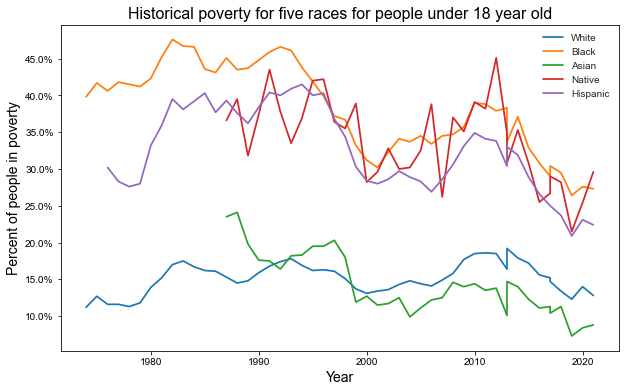

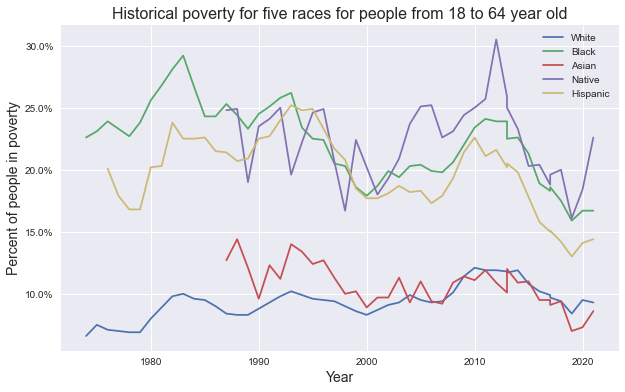

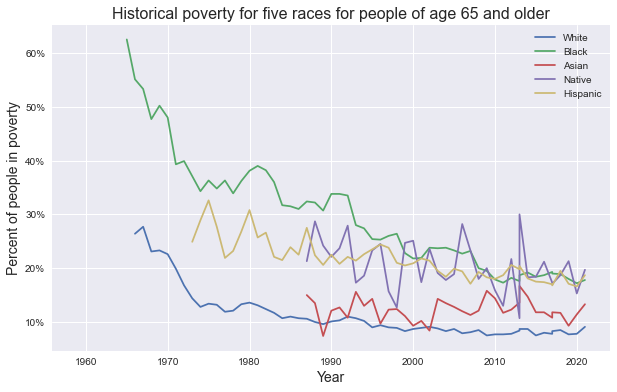

In [8]:
# Plot data for all age groups
lineplot_hist_pov('pct_under_18')
lineplot_hist_pov('pct_18_to_64')
lineplot_hist_pov('pct_over_64')

##### From the graphs above we can observe the following trends:

 - Children: Poverty dropped in the 90s for all groups, returned to the pre-90s level, then dropped again. Today, the situation is better for all groups except white, which anyway is doing way better than most of the rest.
 
 
 - Adults: In the last decade the situation started to get better for all groups, but the pandemic put an end to this trend.
 
 
 - Seniors: Has dropped significantly for Black and white people, slightly decreased for Hispanic people, and stayed the same for Asian and Native Americans.

In [9]:
import pymannkendall as mk

hist_pov_list = [hist_pov_white, hist_pov_black, hist_pov_asian, hist_pov_native, hist_pov_hispanic]
age_groups = ['pct_under_18', 'pct_18_to_64', 'pct_over_64']

# Create an empty (yet) DataFrame which will be transformed to a table later
change_poverty = pd.DataFrame(columns=['Race', 'Age Group', 'Poverty Change', 'Pearson Coef.', 'Pearson P', 'Mann Kendall P'])

for df in hist_pov_list:
    for age_group in age_groups:
        this_array = df[['year', age_group]].dropna()
        
        # Calculate Pearson correlation
        pearson_stat = stats.pearsonr(this_array['year'], this_array[age_group])
        # Mann-Kendall Test to detect trend over time
        mk_stat = mk.original_test(this_array[age_group])
        
        # Create a list and later append it to the DataFrame
        this_row = []
        this_row.append(get_df_name(df).split('_')[2].title())
        this_row.append(' '.join(age_group.split('_')[1:]))
        
        # As no group has become poorer than it was, we add only two options
        # Use alpha value of 0.01
        if pearson_stat[1] < 0.01:
            this_row.append('Decrease')
        else:
            this_row.append("No change")
        
        this_row.append(np.round(pearson_stat[0], 2))
        this_row.append(np.round(pearson_stat[1], 5))
        this_row.append(np.round(mk_stat[2], 5))
        
        change_poverty.loc[len(change_poverty.index)] = this_row

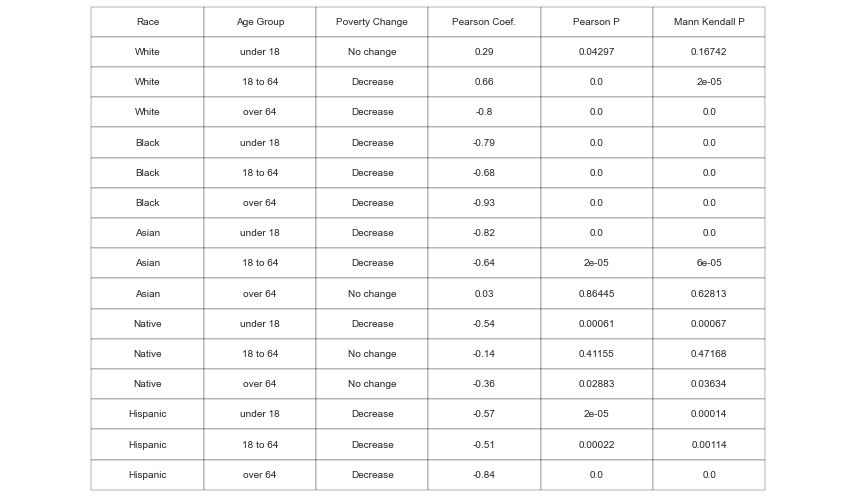

In [10]:
# Create a table
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=change_poverty.values, colLabels=change_poverty.columns, loc='center', cellLoc='center')

fig.tight_layout()
table.scale(0.8, 2)

plt.show()

#### Findings

Most of the groups fare relatively better than a half-century ago. The plus 64 y.o. people of white, Black, and Hispanic origin experienced the biggest decrease in poverty. This is most likely due to the Social Security, undertaken by the government in the middle of the 20th century. More on it [here](https://www.ssa.gov/history/briefhistory3.html). <br>

Another age group that had a significant decrease in poverty for all races but white is children. Nevertheless, today more than 11 million children are considered to be in poverty, that is 15% of all children and  29.4% of all people in poverty (given that children comprise 22.2% of the population in the US).

### Impact of Alternative Resource Measures on Poverty
Additionally, we'd like to explore historical poverty based on different measurements used by the Census. Currently, when measuring poverty the Census doesn't include the impact of noncash programs. But it has data starting from 1981 with five alternative estimations with regard to:
- Official estimation – includes Social Security and Unemployment Insurance.
- Without Social Security, i.e. benefits for people in retirement, disabled people, and survivors.
- Without Unemployment Insurance (UI).
- With Supplemental Nutrition Assistance Program (SNAP) – food stamps for low- or no-income families.
- With Earned Income Tax Credit (EITC) – allows low- to moderate-income workers to take a tax break.

#### Load  and Clean Data

In [11]:
cols_3 = ['year', 'below_pov_official', 'below_pov_pct', 'no_social_sec', 'no_social_sec_pct', 'no_ui', 'no_ui_pct', 'with_snap', 'with_snap_pct' ,'with_eitc', 'with_eitc_pct']
df3 = pd.read_excel('c1_impact_on_pov.xlsx', skiprows=6, usecols="A, C:L", names=cols_3).iloc[1:176]
change_dtypes(df3)

In [12]:
# Split by age
impact_all = extract_rows(df3, 0, 43)
impact_under_18 = extract_rows(df3, 44, 87)
impact_18_to_64 = extract_rows(df3, 88, 131)
impact_over_64 = extract_rows(df3, 132, 175)

#### Explore

First, create a time series with all alternative measures to get the overall impact on the poverty rate. 

In [13]:
def plot_measures(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.plot(df['below_pov_pct'])
    plt.plot(df['no_social_sec_pct'])
    plt.plot(df['no_ui_pct'])
    plt.plot(df['with_snap_pct'])
    plt.plot(df['with_eitc_pct'])

    ax.set_xticks(range(0, len(df['year']), 5))
    ax.set_xticklabels(range(1981, 2022, 5))
    
    plt.ylabel('Percentage of People in Poverty')
    plt.legend(['Official Estimates', 'No Social Security', 'No Unemployment Insurance', 'With SNAP', 'With Earned Income Tax Credit'])
    df_name = ' '.join(get_df_name(df).split('_')[1:])
    plt.title(f'Percentage of People {df_name} Year Old in Poverty with Alternative Resource Measures')
    plt.show()

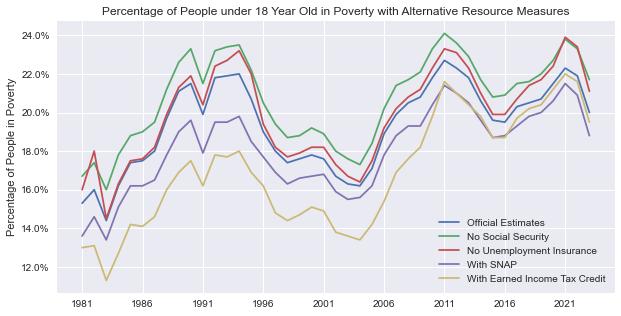

In [14]:
plot_measures(impact_under_18)

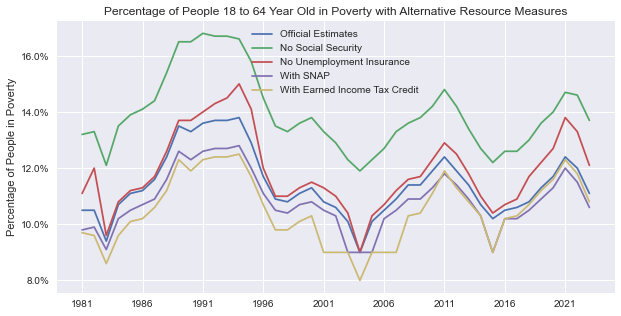

In [15]:
plot_measures(impact_18_to_64)

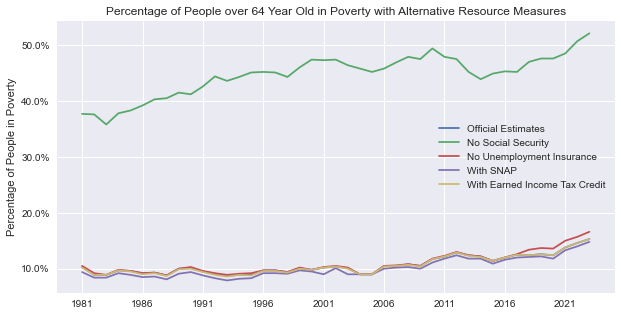

In [16]:
plot_measures(impact_over_64)

#### Findings

For the 18 to 64-year-old group, the biggest difference is observed when social security benefits are not included in the poverty rate calculation (more than a 2% difference). <br>
Also, we can see that with the pandemic outbreak in 2020, the difference in official estimates and with no unemployment insurance has increased (from less than 1% to 1.5%). <br>
Tax breaks made some difference in the late 1990s - early 2000s, but this gap almost closed over time. 

The same trends are observed in the under-18 age group.

In the over-64-year-old group, the most conspicuous difference is when calculating poverty without social security. The estimates are higher than in the historical poverty data from this project's section above before these benefits reached their broad scope.

# Poverty in the United States by Different Group
#### Task
Explore the poverty situation in 2021 and draw conclusions. 


#### Data
The data is split into the following groups: race, sex, age, education attainment, nativity status, region, residence, working experience, and disability status. We'll delete some generalizing rows (e.g. 'Foregn-born in the nativity DataFrame as it is just a sum of 'Naturalized citizen' and 'Not a citizen' rows).


#### Methods
1. Create a series of bar charts to show the percentage of people in poverty in all nine groups (without the context).

2. Use treemaps to  see the difference in the proportion of people in and not in poverty. For that, I chose two groups: race and educational attainment.

#### Load and Clean Data

In [17]:
cols_2 = ['characteristic', 'total', 'below_pov', 'error_margin', 'percentage', 'pct_error']
df2 = pd.read_excel('a1_pov_by_group.xlsx', header=5, usecols="A, G:K", names=cols_2).iloc[0:48]
# Add column to count people above the poverty threshold
df2['not_in_poverty'] = df2.total - df2.below_pov

In [18]:
poverty_race = extract_rows(df2, 3, 10)
poverty_sex = extract_rows(df2, 11, 13)
poverty_age = extract_rows(df2, 14, 17)
poverty_nativity = extract_rows(df2, 18, 22)
poverty_region = extract_rows(df2, 23, 27)
poverty_residence = extract_rows(df2, 28, 32)
poverty_work_experience = extract_rows(df2, 33, 38)
poverty_disability_status = extract_rows(df2, 40, 42)
poverty_educational_attainment = extract_rows(df2, 43, 48)

In [19]:
# Delete generalizing rows and change the names of the characteristics
poverty_race = poverty_race.drop(index=0).reset_index(drop=True)
poverty_race.loc[0, 'characteristic'] = 'White'
poverty_race.loc[3, 'characteristic'] = 'Indigenous'
poverty_nativity = poverty_nativity.drop(index=1).reset_index(drop=True)
poverty_educational_attainment = poverty_educational_attainment.drop(index=0).reset_index(drop=True)
poverty_residence = poverty_residence.drop(index=0).reset_index(drop=True)
poverty_residence.loc[0, 'characteristic'] = 'Urban'
poverty_residence.loc[1, 'characteristic'] = 'Suburban'
poverty_residence.loc[2, 'characteristic'] = 'Rural'

In [20]:
# Lastly add two columns to count percentage a certain group hold from all the people in poverty
# We need it only for two tables - race and education, as we will visualize them on the tree map along with this percentage
def pct_of_total(df):
    df['pct_of_total'] = np.round(df['total'] / np.sum(df['total']), 2)
    df['pct_of_total_below_pov'] = np.round(df['below_pov'] / np.sum(df['below_pov']), 2)
    df['pct_of_total_above_pov'] = np.round(df['not_in_poverty'] / np.sum(df['not_in_poverty']), 2)
    
pct_of_total(poverty_race)
pct_of_total(poverty_educational_attainment)

In [21]:
# All the data types seem to be correct
print(poverty_race.dtypes)

characteristic             object
total                     float64
below_pov                 float64
error_margin              float64
percentage                float64
pct_error                 float64
not_in_poverty            float64
pct_of_total              float64
pct_of_total_below_pov    float64
pct_of_total_above_pov    float64
dtype: object


#### Explore

Create a function that takes in a DataFrame and columns to create bar charts with a given number of subplots.

In [22]:
def bar_plot_by_group(df, subplot_num, x_values, y_values='characteristic'):
    ax = plt.subplot(5, 2, subplot_num)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    sns.barplot(data=df, x=x_values, y=y_values)

    group_name = ' '.join(get_df_name(df).split('_')[1:])
    plt.title(f'Percentage of people in poverty by {group_name}')
    
    plt.xlabel('')
    plt.ylabel('')

At first, I tried to show how the situation differs from group to group with side-by-side bars. But it turned out, that this difference is very hard to discern (for example, the rendered figure below hardly tells us that the percentage of Black people in poverty is roughly two times higher than that of white people).

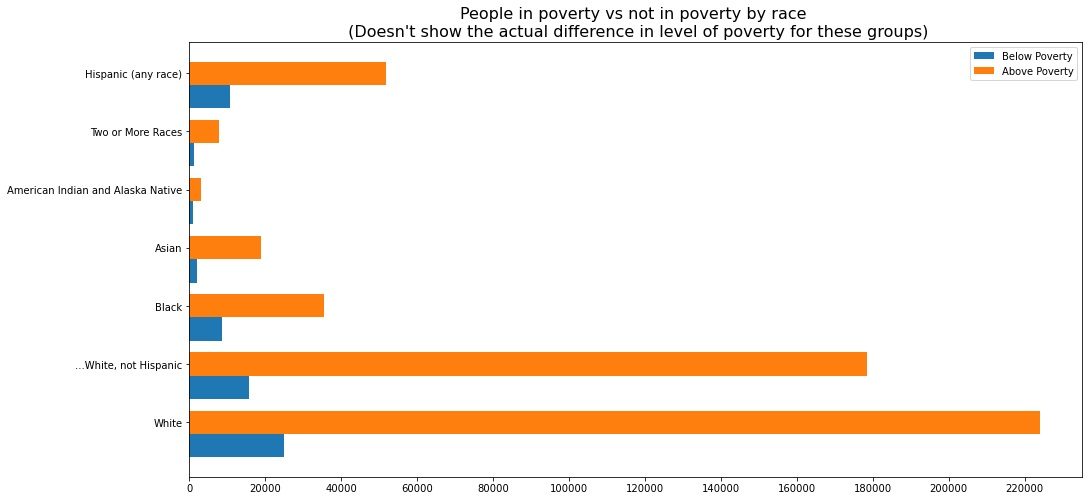

So instead, use percentages instead of absolute values. 

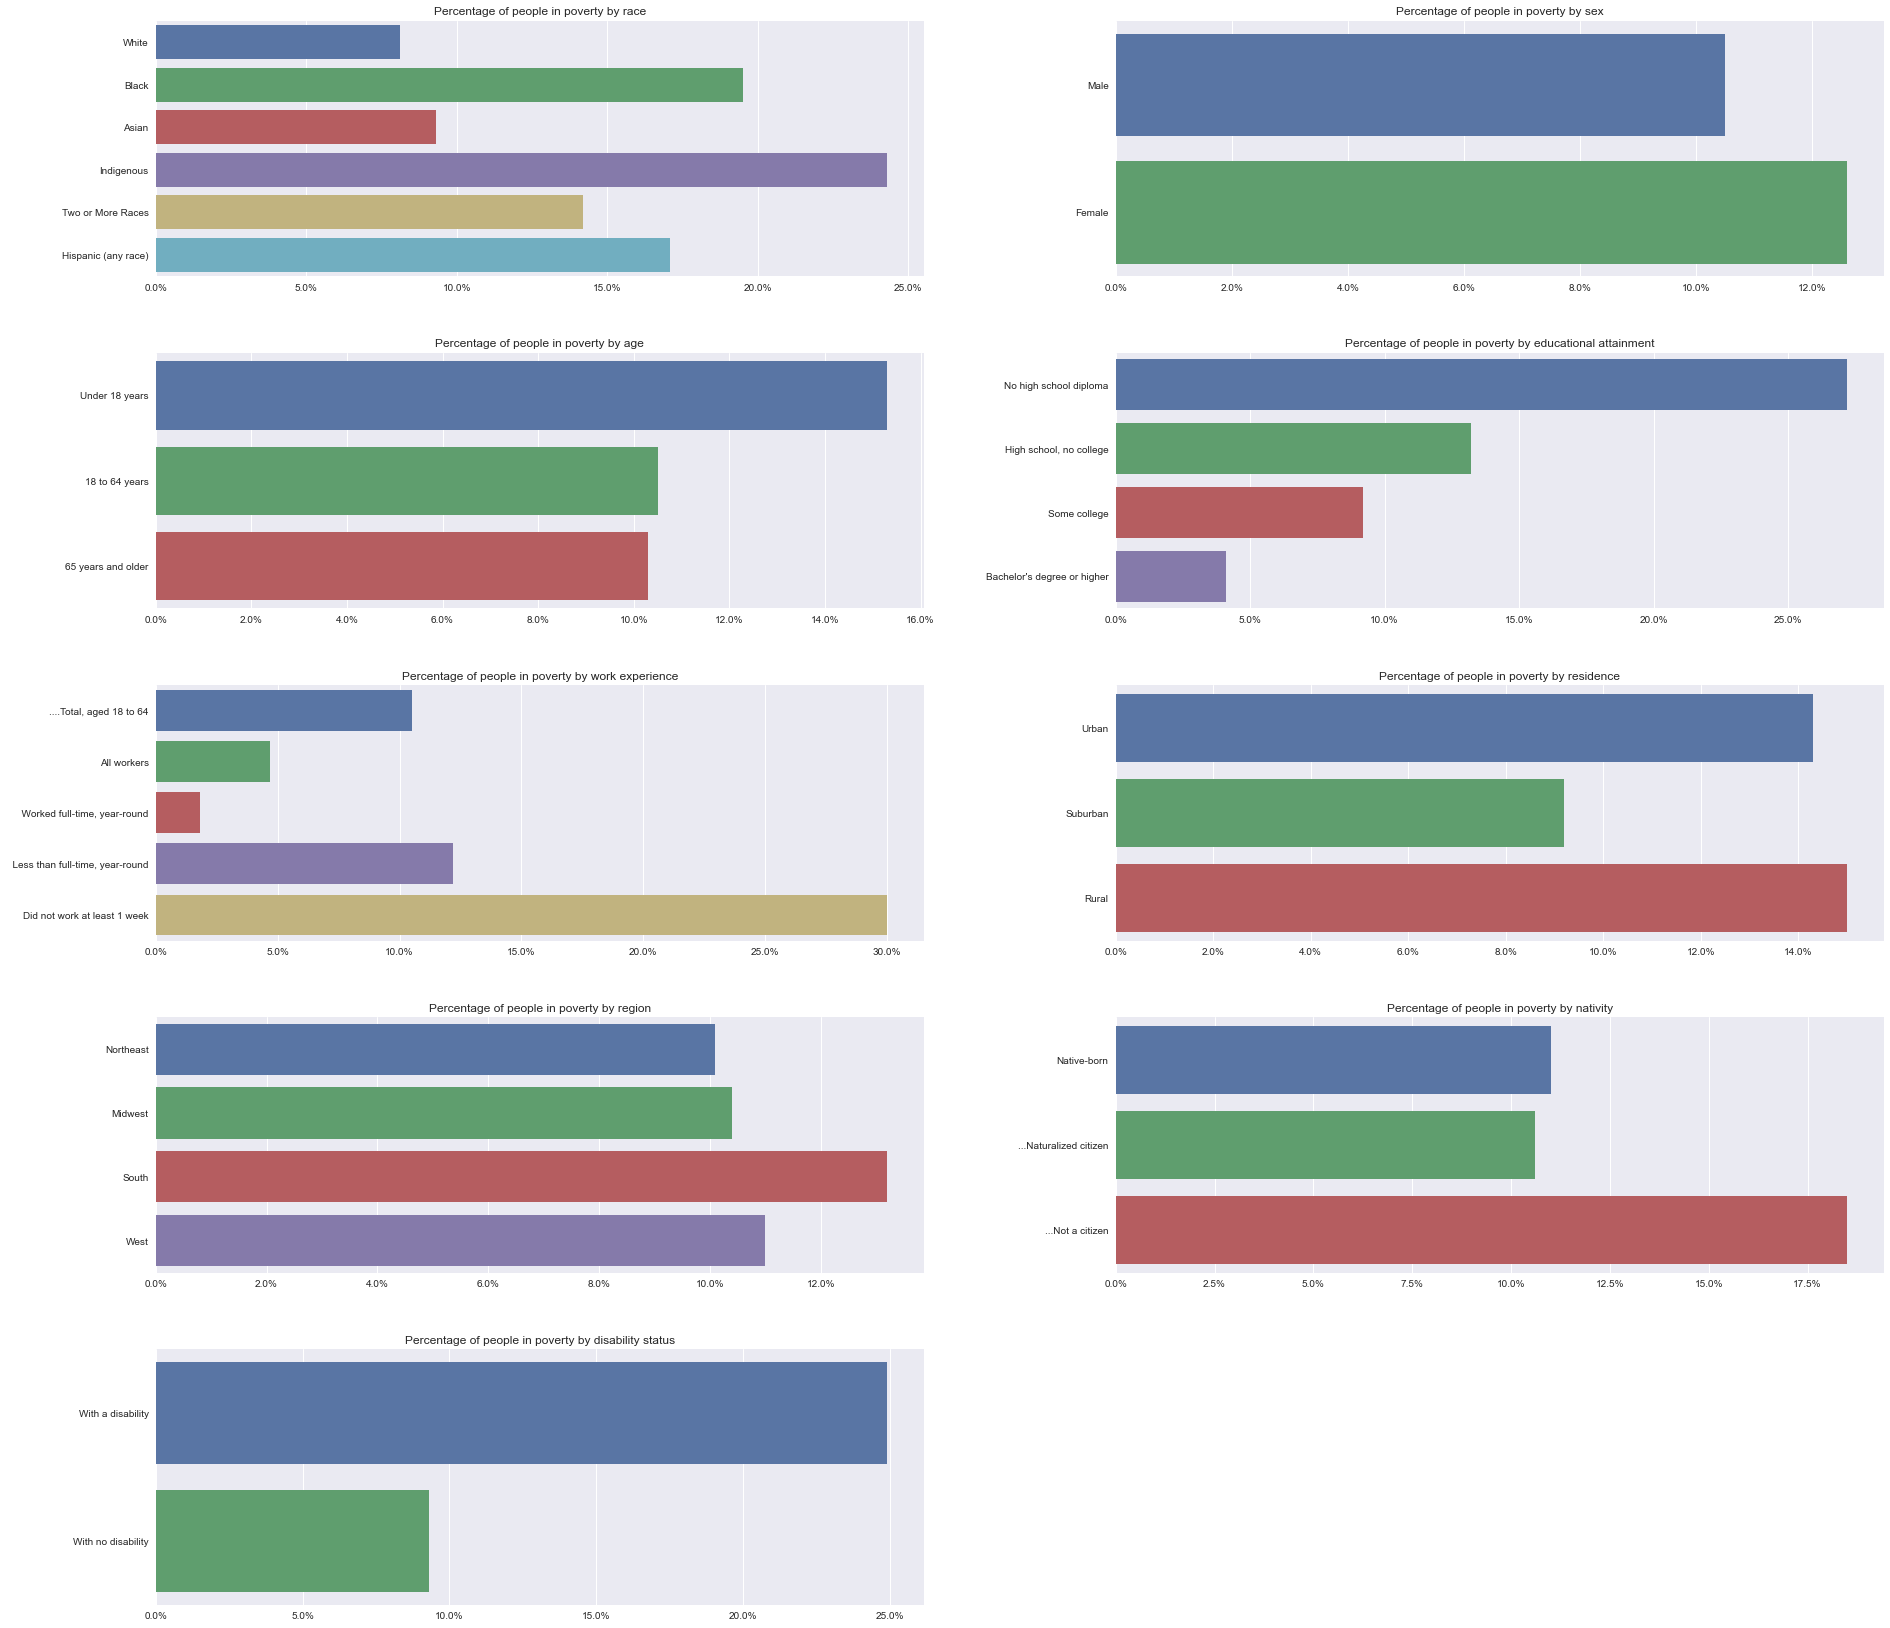

In [23]:
bar_plot_by_group(poverty_race, 1, 'percentage')
bar_plot_by_group(poverty_sex, 2, 'percentage')
bar_plot_by_group(poverty_age, 3, 'percentage')
bar_plot_by_group(poverty_educational_attainment, 4, 'percentage')
bar_plot_by_group(poverty_work_experience, 5, 'percentage')
bar_plot_by_group(poverty_residence, 6, 'percentage')
bar_plot_by_group(poverty_region, 7, 'percentage')
bar_plot_by_group(poverty_nativity, 8, 'percentage')
bar_plot_by_group(poverty_disability_status, 9, 'percentage')


plt.subplots_adjust(wspace=0.25, hspace=0.3, left=-1.5, right=1.5, bottom=-2, top=2)
plt.show()

Next, create two treemaps side by side. The first would show the proportion of people below the poverty and the second above. It would visualize disproportions in the level of poverty for certain groups of people.

In [24]:
def compare_treemap(df):
    
    # First, create a list of labels which comprises a name of a group and a percent below / above poverty
    def create_label_list(df, position):
        paired_values = []
        ind = range(len(df))
        for i in ind:
            paired_values.append(df['characteristic'][i])
            if position == 'below':
                paired_values.append(str(df['pct_of_total_below_pov'][i]))
            else:
                paired_values.append(str(df['pct_of_total_above_pov'][i]))

        label_list = []
        for i in range(0, len(paired_values), 2):
            this_pair = paired_values[i:i+2]
            this_string = ', '.join(this_pair)
            label_list.append(this_string)
            del this_string
        return label_list
    
    
    plt.figure(figsize=(20, 5))
    
    # Plot the left map
    plt.subplot(1, 2, 1)
    
    colors_1 = sns.dark_palette("#C49792")
    labels = create_label_list(df, 'below')
    
    squarify.plot(sizes=df['below_pov'], label=labels, alpha=0.3,color=colors_1)
    plt.axis('off')
    plt.title('Proportion of people in poverty', fontsize=16)

    
    # Plot the right map
    plt.subplot(1, 2, 2)
    
    colors_2 = sns.light_palette('#203f61')
    labels = create_label_list(df, 'above')
    
    squarify.plot(sizes=df['not_in_poverty'], label=labels, alpha=0.8,color=colors_2)
    plt.axis('off')
    plt.title('Proportion of people NOT in poverty', fontsize=16)
    
    
    plt.show()

These maps clearly demonstrate the disproportional distribution of poverty for different groups. For example, on the upper right graph, white people take up 60% of the map (60% of all people not in poverty are white), and on the upper left graph – 40% (this percentage of all people in poverty are white).

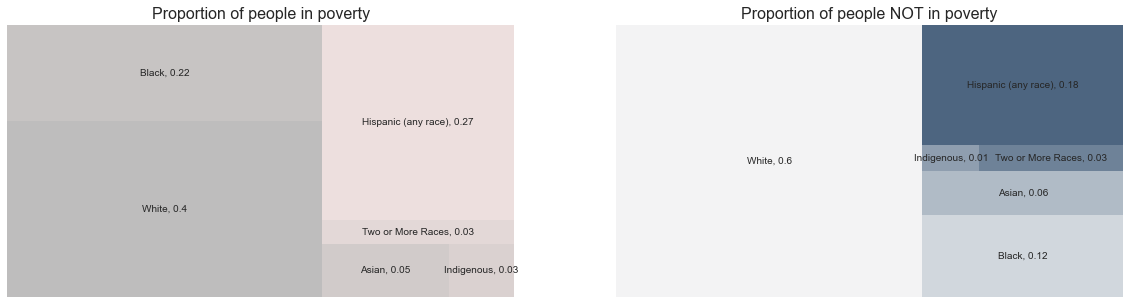

In [25]:
compare_treemap(poverty_race)

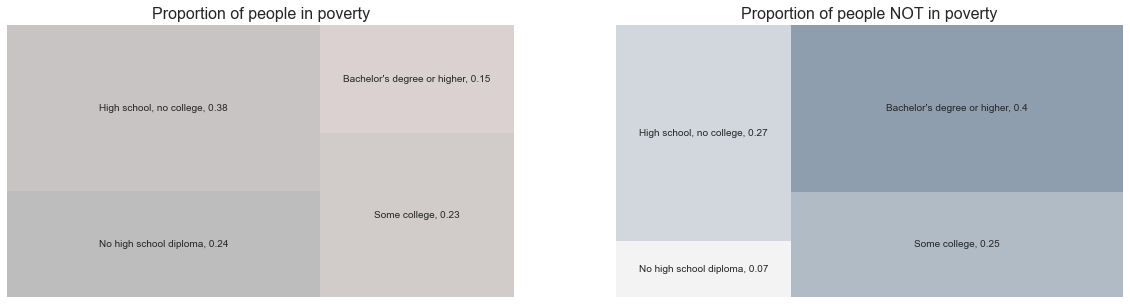

In [26]:
compare_treemap(poverty_educational_attainment)

In [27]:
# Explore the general numbers
total_statistics = df2.iloc[1]
print(f"About {total_statistics['below_pov']} thousand people live in poverty")
print(f"{total_statistics['percentage']}% of people live in poverty")

About 37933.0 thousand people live in poverty
11.6% of people live in poverty


#### Findings

Out of all people who are considered to live below the poverty, there are certain disproportions. There is almost a 5% difference in relative poverty between children and adults. Data confirms that people from minority groups are more likely to be poor. Despite a decrease in poverty for Black and Hispanic people, they are 17 to 23 percent gap in relative poverty between these groups and white and Asian.  <br>
The difference is vast in other obvious examples – between rural/urban and suburban dwellers (more than 5%), people with a college degree and no degree (up to 10%), and people with and without disability (> 15%). <br> Also, there is a significant difference between men and women (2%).

# Conclusion

#### What's done
We created several functions to perform data cleaning and visualization and tested them with our data. Among them are functions that do the following:
- Extract certain rows from the DataFrame and change the data types;
- Get the name of a DataFrame as a string;
- Create and customize a line chart of historical change for five races which takes an age group as a parameter;
- Find Pearson correlation and p-value and perform the Mann-Kendall test, and append the results to a new DataFrame (this one was performed outside a function definition);
- Create and customize a line chart of historical change for three age groups based on different measurements of poverty;
- Create and customize a series of bar charts to show the percentage of people in poverty in nine different groups;
- Create two treemaps to show what percentage of people are in and not in poverty based on a given group.


#### Key findings
Today, most of the groups (by race, age, and other categories) are doing relatively better than fifty years ago. Senior and child poverty has decreased the most dramatically. Yet, the situation is very far from ideal. The group with the least decrease in poverty is Native Americans (no change for adults and very little change for children).

Including noncash programs in the measurement decreased the poverty rate, but not very much (especially, since the late 2000s). Excluding social security raises this rate by 1-3% (and by 35% for retirees), and the difference when excluding unemployment benefits is the most conspicuous in the pandemic years. 

Despite the overall drop in poverty over the years, data confirms that people from minority groups are still more likely to be poor, sometimes with a vast difference.

#### What's next
The next step is to perform exploratory data analysis with data on income and income distribution from the same Census data from 2021.